In [1]:
import os
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, models
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import LinearLR, CosineAnnealingLR, SequentialLR
from tqdm import tqdm
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import torchvision.models.detection
from torchvision.models.detection import FasterRCNN_ResNet50_FPN_Weights
import numpy as np
import matplotlib.pyplot as plt


# Đường dẫn dataset
DATASET_DIR = '/kaggle/input/exdark-gan-bm3d/temp'
IMAGES_DIR = os.path.join(DATASET_DIR, 'ExDark')
ANNOTATIONS_DIR = os.path.join(DATASET_DIR, 'ExDark_Annno')
ENHANCED_IMAGES_DIR = os.path.join(DATASET_DIR, 'Combined_Enhanced_ExDark')

In [2]:
# Hàm đọc annotations từ cấu trúc thư mục phân cấp
def read_annotations(annotations_dir, images_dir):
    annotations = {}
    
    # Duyệt qua tất cả các thư mục class trong ExDark_Annno
    if not os.path.exists(annotations_dir):
        print(f"Annotations directory not found: {annotations_dir}")
        return {}
    
    for class_folder in os.listdir(annotations_dir):
        class_anno_path = os.path.join(annotations_dir, class_folder)
        if not os.path.isdir(class_anno_path):
            continue
            
        # Duyệt qua thư mục con (có thể có thêm 1 lớp thư mục class)
        for subfolder in os.listdir(class_anno_path):
            subfolder_path = os.path.join(class_anno_path, subfolder)
            if os.path.isdir(subfolder_path):
                # Nếu có thêm 1 lớp thư mục con
                annotation_files_path = subfolder_path
                # print(f"Found subfolder for class {class_folder}: {subfolder_path}")
            else:
                # Nếu file annotation nằm trực tiếp trong thư mục class
                annotation_files_path = class_anno_path
                # print(f"Using class folder for annotations: {class_anno_path}")
                break
        
        # Đọc các file annotation
        if os.path.exists(annotation_files_path):
            for filename in os.listdir(annotation_files_path):
                if filename.endswith('.txt'):
                    # Tìm file ảnh tương ứng
                    img_name_base = filename.replace('.txt', '')
                    
                    # Tìm file ảnh trong thư mục class tương ứng
                    img_class_path = os.path.join(images_dir, class_folder)
                    img_path = None
                    
                    if os.path.exists(img_class_path):
                        for img_file in os.listdir(img_class_path):
                            if img_file.startswith(img_name_base):
                                img_path = os.path.join(class_folder, img_file)
                                # print(f"Found image for annotation {filename}: {img_path}")
                                break
                    
                    if img_path is None:
                        continue
                    
                    # Đọc annotations từ file txt
                    anno_file_path = os.path.join(annotation_files_path, filename)
                    with open(anno_file_path, 'r') as f:
                        lines = f.readlines()
                        objs = []
                        
                        for line in lines:
                            line = line.strip()
                            if line.startswith('%') or not line:  # Bỏ qua comment và dòng trống
                                continue
                                
                            parts = line.split()
                            if len(parts) < 7:  # Ít nhất cần có label, width, height, xmin, ymin, xmax, ymax
                                continue
                            
                            try:
                                label = parts[0]
                                xmin = float(parts[1])
                                ymin = float(parts[2])
                                bbox_width = float(parts[3])
                                bbox_height = float(parts[4])
                                
                                # Chuyển đổi sang format [x
                                xmax = xmin + bbox_width
                                ymax = ymin + bbox_height
                                bbox = [xmin, ymin, xmax, ymax]
                                
                                objs.append({
                                    'label': label,
                                    'bbox': bbox
                                })
                                
                                # print(f"Parsed object: {label}, bbox: {bbox}, img_size: ({width}, {height})")
                            except ValueError:
                                print(f"Error parsing line in {filename}: {line}")
                                continue
                        
                        if objs:  # Chỉ thêm vào nếu có objects
                            annotations[img_path] = objs
    
    print(f"Loaded annotations for {len(annotations)} images")
    return annotations


In [3]:
# Hàm tạo label map từ annotations
def create_label_map(annotations):
    label2idx = {}
    idx = 1
    for objs in annotations.values():
        for obj in objs:
            label = obj['label']
            if label not in label2idx:
                label2idx[label] = idx
                idx += 1
    return label2idx

In [4]:
# Dataset cho object detection
class ExDarkDataset(Dataset):
    def __init__(self, img_dir, annotations, label2idx, transform=None):
        self.img_dir = img_dir
        self.annotations = annotations
        self.label2idx = label2idx
        self.transform = transform
        self.img_files = list(annotations.keys())
        
        print(f"Dataset initialized with {len(self.img_files)} images")
        if len(self.img_files) > 0:
            print(f"Sample image paths: {self.img_files[:10]}")

    def __len__(self):
        return len(self.img_files)

    def __getitem__(self, idx):
        img_file = self.img_files[idx]
        img_full_path = os.path.join(self.img_dir, img_file)
        
        # Kiểm tra file có tồn tại không
        if not os.path.exists(img_full_path):
            print(f"Image not found: {img_full_path}")
            # Thử tìm với các extension khác
            base_path = os.path.splitext(img_full_path)[0]
            for ext in ['.jpg', '.png', '.jpeg', '.JPG']:
                if os.path.exists(base_path + ext):
                    img_full_path = base_path + ext
                    break
        
        try:
            image = Image.open(img_full_path).convert("RGB")
        except Exception as e:
            print(f"Error loading image {img_full_path}: {e}")
            # Tạo ảnh trắng thay thế
            image = Image.new('RGB', (224, 224), color='white')

        objs = self.annotations[img_file]
        boxes = []
        labels = []
        
        for obj in objs:
            bbox = obj['bbox']
            # Đảm bảo bbox có định dạng [xmin, ymin, xmax, ymax] cho Faster R-CNN
            xmin, ymin, xmax, ymax = bbox
            boxes.append([xmin, ymin, xmax, ymax])
            labels.append(self.label2idx[obj['label']])

        # Chuyển đổi sang tensor
        boxes = torch.tensor(boxes, dtype=torch.float32)
        labels = torch.tensor(labels, dtype=torch.int64)
        
        # Tạo target dict
        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        target['image_id'] = torch.tensor([idx])

        if self.transform:
            image = self.transform(image)

        return image, target

# Transform ảnh
train_transform = transforms.Compose([
    transforms.ToTensor()
])

# Đọc annotations và tạo label map
print("Loading annotations...")
annotations = read_annotations(ANNOTATIONS_DIR, ENHANCED_IMAGES_DIR)

print("Creating label map...")
label2idx = create_label_map(annotations)

Loading annotations...
Loaded annotations for 7360 images
Creating label map...


In [5]:
# Tạo dataset
print("Creating dataset...")
dataset = ExDarkDataset(
    img_dir=ENHANCED_IMAGES_DIR,
    annotations=annotations,
    label2idx=label2idx,
    transform=train_transform
)
print(f"Dataset size: {len(dataset)}")
try:
    sample_img, sample_target = dataset[0]
    print(f"Sample image shape: {sample_img.shape}")
    print(f"Sample target: {sample_target}")
except Exception as e:
    print(f"Error loading sample: {e}")

# Chia dataset train/val/test
def split_dataset(dataset, train_ratio=0.7, val_ratio=0.1):
    total = len(dataset)
    train_len = int(total * train_ratio)
    val_len = int(total * val_ratio)
    test_len = total - train_len - val_len
    return random_split(dataset, [train_len, val_len, test_len])

train_set, val_set, test_set = split_dataset(dataset)
print(f"Train: {len(train_set)}, Val: {len(val_set)}, Test: {len(test_set)}")

# Custom collate function cho object detection
def collate_fn(batch):
    return tuple(zip(*batch))

train_loader = DataLoader(train_set, batch_size=4, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_set, batch_size=4, shuffle=False, collate_fn=collate_fn)

Creating dataset...
Dataset initialized with 7360 images
Sample image paths: ['Motorbike/2015_06098.jpg', 'Motorbike/2015_06044.JPG', 'Motorbike/2015_05956.jpg', 'Motorbike/2015_05958.jpg', 'Motorbike/2015_06047.JPG', 'Motorbike/2015_05886.jpg', 'Motorbike/2015_06054.JPG', 'Motorbike/2015_06187.jpg', 'Motorbike/2015_05993.jpg', 'Motorbike/2015_06090.jpg']
Dataset size: 7360
Sample image shape: torch.Size([3, 746, 770])
Sample target: {'boxes': tensor([[304.,  84., 491., 347.],
        [278., 258., 522., 721.]]), 'labels': tensor([1, 2]), 'image_id': tensor([0])}
Train: 5152, Val: 736, Test: 1472


In [6]:
# Sử dụng model Faster R-CNN cho object detection

def get_detection_model(num_classes):
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model

num_classes = len(label2idx) + 1  # +1 cho background
print(f"Number of classes: {num_classes}")
        
model = get_detection_model(num_classes)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
model.to(device)

Number of classes: 13


Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:00<00:00, 200MB/s]


Using device: cuda


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [7]:
def calculate_iou(box1, box2):
    """Tính IoU giữa 2 bounding boxes"""
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])
    
    if x2 <= x1 or y2 <= y1:
        return 0.0
    
    intersection = (x2 - x1) * (y2 - y1)
    area1 = (box1[2] - box1[0]) * (box1[3] - box1[1])
    area2 = (box2[2] - box2[0]) * (box2[3] - box2[1])
    union = area1 + area2 - intersection
    
    return intersection / union

def calculate_ap(precisions, recalls):
    """Tính Average Precision"""
    if len(precisions) == 0:
        return 0.0
    
    recalls = np.concatenate(([0], recalls, [1]))
    precisions = np.concatenate(([0], precisions, [0]))
    
    for i in range(len(precisions) - 2, -1, -1):
        precisions[i] = max(precisions[i], precisions[i + 1])
    
    indices = np.where(recalls[1:] != recalls[:-1])[0] + 1
    ap = np.sum((recalls[indices] - recalls[indices - 1]) * precisions[indices])
    return ap

def evaluate_faster_rcnn(predictions, ground_truths):
    """Tính mAP cho Faster R-CNN"""
    iou_threshold=0.5
    # Tạo idx2label để map ngược lại tên class
    idx2label = {v: k for k, v in label2idx.items()}
    
    # Lấy tất cả classes (loại bỏ background class = 0)
    all_classes = set()
    for gt in ground_truths:
        all_classes.update(gt['labels'])
    all_classes = sorted([c for c in all_classes if c > 0])  # Loại bỏ background
    
    if len(all_classes) == 0:
        return 0.0
    
    class_aps = []
    
    for class_id in all_classes:
        detections = []
        num_gt = 0
        
        for img_idx, (pred, gt) in enumerate(zip(predictions, ground_truths)):
            # Ground truth cho class này
            gt_mask = gt['labels'] == class_id
            gt_boxes_class = gt['boxes'][gt_mask]
            num_gt += len(gt_boxes_class)
            
            # Predictions cho class này
            pred_mask = pred['labels'] == class_id
            pred_boxes_class = pred['boxes'][pred_mask]
            pred_scores_class = pred['scores'][pred_mask]
            
            for box, score in zip(pred_boxes_class, pred_scores_class):
                detections.append({
                    'image_idx': img_idx,
                    'box': box,
                    'score': score,
                    'gt_boxes': gt_boxes_class
                })
        
        if num_gt == 0 or len(detections) == 0:
            class_aps.append(0.0)
            continue
        
        # Sắp xếp theo confidence
        detections.sort(key=lambda x: x['score'], reverse=True)
        
        tp = np.zeros(len(detections))
        fp = np.zeros(len(detections))
        matched_gt = {}
        
        for det_idx, detection in enumerate(detections):
            img_idx = detection['image_idx']
            pred_box = detection['box']
            gt_boxes = detection['gt_boxes']
            
            if img_idx not in matched_gt:
                matched_gt[img_idx] = [False] * len(gt_boxes)
            
            max_iou = 0
            max_gt_idx = -1
            
            for gt_idx, gt_box in enumerate(gt_boxes):
                if not matched_gt[img_idx][gt_idx]:
                    iou = calculate_iou(pred_box, gt_box)
                    if iou > max_iou:
                        max_iou = iou
                        max_gt_idx = gt_idx
            
            if max_iou >= iou_threshold and max_gt_idx != -1:
                tp[det_idx] = 1
                matched_gt[img_idx][max_gt_idx] = True
            else:
                fp[det_idx] = 1
        
        tp_cumsum = np.cumsum(tp)
        fp_cumsum = np.cumsum(fp)
        
        precisions = tp_cumsum / (tp_cumsum + fp_cumsum)
        recalls = tp_cumsum / num_gt
        
        ap = calculate_ap(precisions, recalls)
        class_aps.append(ap)
        
        # In ra tên class thay vì class ID
        class_name = idx2label.get(class_id, f"Class_{class_id}")
        print(f"Class '{class_name}' (ID: {class_id}): AP = {ap:.4f}")
    
    mAP = np.mean(class_aps) if class_aps else 0.0
    return mAP

In [8]:
def evaluate(model, test_loader):
    """Hàm đánh giá model - chỉ trả về mAP"""
    model.eval()
    predictions = []
    ground_truths = []
    
    print("Starting evaluation...")
    
    with torch.no_grad():
        for batch_idx, (images, targets) in enumerate(tqdm(test_loader, desc="Evaluating")):
            # Chuyển images và targets lên device
            images = [img.to(device) for img in images]
            targets = [{k: v.to(device) if isinstance(v, torch.Tensor) else v for k, v in t.items()} for t in targets]
            
            # Forward pass
            outputs = model(images)
            
            # Thu thập predictions và ground truths
            for output, target in zip(outputs, targets):
                # Lọc predictions có confidence > threshold
                predictions.append({
                    'boxes': output['boxes'].cpu().numpy(),
                    'labels': output['labels'].cpu().numpy(),
                    'scores': output['scores'].cpu().numpy()
                })
                
                ground_truths.append({
                    'boxes': target['boxes'].cpu().numpy(),
                    'labels': target['labels'].cpu().numpy()
                })
    
    print(f"Collected {len(predictions)} predictions and {len(ground_truths)} ground truths")
    
    # Tính mAP
    mAP = evaluate_faster_rcnn(predictions, ground_truths)
    
    return mAP

In [9]:
# Lưu model
def save_model(model, path='/kaggle/working/GAN_Faster_RCNN.pth'):
    torch.save(model.state_dict(), path)
    print(f"Model saved to {path}")

In [10]:
train_losses = []
train_accuracies = []

# Hàm train model
def train_model(model, train_loader, val_loader, epochs=20, lr=4e-5, warmup_epochs=2, max_norm=1.0):
    best_mAP = -float('inf')
    # Initialize parameters and optimizer
    params = [p for p in model.parameters() if p.requires_grad]
    optimizer = optim.Adam(params, lr=lr, weight_decay=1e-4)
    
    # Learning rate scheduler
    base_lr = lr
    scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(
        optimizer, T_0=epochs, T_mult=1, eta_min=lr/100
    )
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        num_batches = 0
        
        print(f"\nEpoch {epoch+1}/{epochs}")
        loop = tqdm(train_loader, desc="Training")
        
        for images, targets in loop:
            try:
                # Move images and targets to device
                images = [img.to(device) for img in images]
                targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
                
                # Forward pass
                loss_dict = model(images, targets)
                losses = sum(loss for loss in loss_dict.values())
                
                # Backward pass
                optimizer.zero_grad()
                losses.backward()
                
                # Gradient clipping
                torch.nn.utils.clip_grad_norm_(params, max_norm)
                
                optimizer.step()
                
                # Update loss
                train_loss += losses.item()
                num_batches += 1
                
                # Update progress bar
                avg_loss = train_loss / num_batches if num_batches > 0 else 0
                loop.set_postfix(loss=avg_loss)
                
            except Exception as e:
                print(f"Error in batch: {e}")
                continue
        
        # Step the scheduler
        scheduler.step()
        
        # Calculate average loss
        avg_loss = train_loss / num_batches if num_batches > 0 else 0
        train_losses.append(avg_loss)
        
        # Evaluate on validation set if provided
        val_accuracy = evaluate(model, val_loader)
        if val_accuracy > best_mAP:
            best_mAP = val_accuracy
            save_model(model)
            
        train_accuracies.append(val_accuracy)
        
        print(f"Epoch {epoch+1}/{epochs}, Avg Loss: {avg_loss:.4f}, mAP: {val_accuracy:.4f}, LR: {scheduler.get_last_lr()[0]:.6f}")
    
    return model


In [11]:
model = train_model(model, train_loader, val_loader)


Epoch 1/20


Training: 100%|██████████| 1288/1288 [16:46<00:00,  1.28it/s, loss=0.467]


Starting evaluation...


Evaluating: 100%|██████████| 184/184 [01:16<00:00,  2.41it/s]


Collected 736 predictions and 736 ground truths
Class 'People' (ID: 1): AP = 0.7401
Class 'Motorbike' (ID: 2): AP = 0.6266
Class 'Car' (ID: 3): AP = 0.7088
Class 'Bicycle' (ID: 4): AP = 0.6984
Class 'Bus' (ID: 5): AP = 0.7900
Class 'Bottle' (ID: 6): AP = 0.6219
Class 'Chair' (ID: 7): AP = 0.5096
Class 'Table' (ID: 8): AP = 0.4762
Class 'Cup' (ID: 9): AP = 0.5271
Class 'Dog' (ID: 10): AP = 0.6444
Class 'Boat' (ID: 11): AP = 0.6142
Class 'Cat' (ID: 12): AP = 0.4172
Model saved to /kaggle/working/GAN_Faster_RCNN.pth
Epoch 1/20, Avg Loss: 0.4673, mAP: 0.6145, LR: 0.000040

Epoch 2/20


Training: 100%|██████████| 1288/1288 [16:17<00:00,  1.32it/s, loss=0.37]


Starting evaluation...


Evaluating: 100%|██████████| 184/184 [01:12<00:00,  2.55it/s]


Collected 736 predictions and 736 ground truths
Class 'People' (ID: 1): AP = 0.7612
Class 'Motorbike' (ID: 2): AP = 0.7371
Class 'Car' (ID: 3): AP = 0.7520
Class 'Bicycle' (ID: 4): AP = 0.7935
Class 'Bus' (ID: 5): AP = 0.7321
Class 'Bottle' (ID: 6): AP = 0.6289
Class 'Chair' (ID: 7): AP = 0.5334
Class 'Table' (ID: 8): AP = 0.5030
Class 'Cup' (ID: 9): AP = 0.6495
Class 'Dog' (ID: 10): AP = 0.6348
Class 'Boat' (ID: 11): AP = 0.6652
Class 'Cat' (ID: 12): AP = 0.5972
Model saved to /kaggle/working/GAN_Faster_RCNN.pth
Epoch 2/20, Avg Loss: 0.3698, mAP: 0.6657, LR: 0.000039

Epoch 3/20


Training: 100%|██████████| 1288/1288 [16:12<00:00,  1.32it/s, loss=0.325]


Starting evaluation...


Evaluating: 100%|██████████| 184/184 [01:12<00:00,  2.54it/s]


Collected 736 predictions and 736 ground truths
Class 'People' (ID: 1): AP = 0.7763
Class 'Motorbike' (ID: 2): AP = 0.6545
Class 'Car' (ID: 3): AP = 0.7620
Class 'Bicycle' (ID: 4): AP = 0.7606
Class 'Bus' (ID: 5): AP = 0.7870
Class 'Bottle' (ID: 6): AP = 0.6720
Class 'Chair' (ID: 7): AP = 0.5423
Class 'Table' (ID: 8): AP = 0.5692
Class 'Cup' (ID: 9): AP = 0.6624
Class 'Dog' (ID: 10): AP = 0.6285
Class 'Boat' (ID: 11): AP = 0.7281
Class 'Cat' (ID: 12): AP = 0.6926
Model saved to /kaggle/working/GAN_Faster_RCNN.pth
Epoch 3/20, Avg Loss: 0.3249, mAP: 0.6863, LR: 0.000038

Epoch 4/20


Training: 100%|██████████| 1288/1288 [16:15<00:00,  1.32it/s, loss=0.288]


Starting evaluation...


Evaluating: 100%|██████████| 184/184 [01:12<00:00,  2.55it/s]


Collected 736 predictions and 736 ground truths
Class 'People' (ID: 1): AP = 0.7607
Class 'Motorbike' (ID: 2): AP = 0.7140
Class 'Car' (ID: 3): AP = 0.7791
Class 'Bicycle' (ID: 4): AP = 0.7792
Class 'Bus' (ID: 5): AP = 0.8091
Class 'Bottle' (ID: 6): AP = 0.7328
Class 'Chair' (ID: 7): AP = 0.5558
Class 'Table' (ID: 8): AP = 0.5126
Class 'Cup' (ID: 9): AP = 0.6340
Class 'Dog' (ID: 10): AP = 0.6468
Class 'Boat' (ID: 11): AP = 0.7141
Class 'Cat' (ID: 12): AP = 0.6518
Model saved to /kaggle/working/GAN_Faster_RCNN.pth
Epoch 4/20, Avg Loss: 0.2876, mAP: 0.6908, LR: 0.000036

Epoch 5/20


Training: 100%|██████████| 1288/1288 [16:19<00:00,  1.32it/s, loss=0.26]


Starting evaluation...


Evaluating: 100%|██████████| 184/184 [01:12<00:00,  2.54it/s]


Collected 736 predictions and 736 ground truths
Class 'People' (ID: 1): AP = 0.7380
Class 'Motorbike' (ID: 2): AP = 0.7127
Class 'Car' (ID: 3): AP = 0.7594
Class 'Bicycle' (ID: 4): AP = 0.8315
Class 'Bus' (ID: 5): AP = 0.8027
Class 'Bottle' (ID: 6): AP = 0.7185
Class 'Chair' (ID: 7): AP = 0.5635
Class 'Table' (ID: 8): AP = 0.5338
Class 'Cup' (ID: 9): AP = 0.6645
Class 'Dog' (ID: 10): AP = 0.7021
Class 'Boat' (ID: 11): AP = 0.7286
Class 'Cat' (ID: 12): AP = 0.6635
Model saved to /kaggle/working/GAN_Faster_RCNN.pth
Epoch 5/20, Avg Loss: 0.2596, mAP: 0.7016, LR: 0.000034

Epoch 6/20


Training: 100%|██████████| 1288/1288 [16:14<00:00,  1.32it/s, loss=0.234]


Starting evaluation...


Evaluating: 100%|██████████| 184/184 [01:12<00:00,  2.54it/s]


Collected 736 predictions and 736 ground truths
Class 'People' (ID: 1): AP = 0.7484
Class 'Motorbike' (ID: 2): AP = 0.7494
Class 'Car' (ID: 3): AP = 0.7249
Class 'Bicycle' (ID: 4): AP = 0.7939
Class 'Bus' (ID: 5): AP = 0.7722
Class 'Bottle' (ID: 6): AP = 0.6784
Class 'Chair' (ID: 7): AP = 0.5882
Class 'Table' (ID: 8): AP = 0.5196
Class 'Cup' (ID: 9): AP = 0.6388
Class 'Dog' (ID: 10): AP = 0.6549
Class 'Boat' (ID: 11): AP = 0.7293
Class 'Cat' (ID: 12): AP = 0.6869
Epoch 6/20, Avg Loss: 0.2340, mAP: 0.6904, LR: 0.000032

Epoch 7/20


Training: 100%|██████████| 1288/1288 [16:21<00:00,  1.31it/s, loss=0.212]


Starting evaluation...


Evaluating: 100%|██████████| 184/184 [01:13<00:00,  2.50it/s]


Collected 736 predictions and 736 ground truths
Class 'People' (ID: 1): AP = 0.7435
Class 'Motorbike' (ID: 2): AP = 0.7441
Class 'Car' (ID: 3): AP = 0.7453
Class 'Bicycle' (ID: 4): AP = 0.7495
Class 'Bus' (ID: 5): AP = 0.7780
Class 'Bottle' (ID: 6): AP = 0.6981
Class 'Chair' (ID: 7): AP = 0.4847
Class 'Table' (ID: 8): AP = 0.4853
Class 'Cup' (ID: 9): AP = 0.6120
Class 'Dog' (ID: 10): AP = 0.6695
Class 'Boat' (ID: 11): AP = 0.6534
Class 'Cat' (ID: 12): AP = 0.6382
Epoch 7/20, Avg Loss: 0.2124, mAP: 0.6668, LR: 0.000029

Epoch 8/20


Training: 100%|██████████| 1288/1288 [16:22<00:00,  1.31it/s, loss=0.19]


Starting evaluation...


Evaluating: 100%|██████████| 184/184 [01:12<00:00,  2.54it/s]


Collected 736 predictions and 736 ground truths
Class 'People' (ID: 1): AP = 0.7399
Class 'Motorbike' (ID: 2): AP = 0.7460
Class 'Car' (ID: 3): AP = 0.7579
Class 'Bicycle' (ID: 4): AP = 0.8359
Class 'Bus' (ID: 5): AP = 0.7666
Class 'Bottle' (ID: 6): AP = 0.7146
Class 'Chair' (ID: 7): AP = 0.5604
Class 'Table' (ID: 8): AP = 0.5264
Class 'Cup' (ID: 9): AP = 0.6868
Class 'Dog' (ID: 10): AP = 0.7487
Class 'Boat' (ID: 11): AP = 0.7225
Class 'Cat' (ID: 12): AP = 0.6567
Model saved to /kaggle/working/GAN_Faster_RCNN.pth
Epoch 8/20, Avg Loss: 0.1904, mAP: 0.7052, LR: 0.000026

Epoch 9/20


Training: 100%|██████████| 1288/1288 [16:12<00:00,  1.32it/s, loss=0.171]


Starting evaluation...


Evaluating: 100%|██████████| 184/184 [01:12<00:00,  2.52it/s]


Collected 736 predictions and 736 ground truths
Class 'People' (ID: 1): AP = 0.7450
Class 'Motorbike' (ID: 2): AP = 0.7649
Class 'Car' (ID: 3): AP = 0.7295
Class 'Bicycle' (ID: 4): AP = 0.7858
Class 'Bus' (ID: 5): AP = 0.7765
Class 'Bottle' (ID: 6): AP = 0.6881
Class 'Chair' (ID: 7): AP = 0.5764
Class 'Table' (ID: 8): AP = 0.5245
Class 'Cup' (ID: 9): AP = 0.6410
Class 'Dog' (ID: 10): AP = 0.6777
Class 'Boat' (ID: 11): AP = 0.6513
Class 'Cat' (ID: 12): AP = 0.7412
Epoch 9/20, Avg Loss: 0.1714, mAP: 0.6918, LR: 0.000023

Epoch 10/20


Training: 100%|██████████| 1288/1288 [16:12<00:00,  1.32it/s, loss=0.154]


Starting evaluation...


Evaluating: 100%|██████████| 184/184 [01:11<00:00,  2.56it/s]


Collected 736 predictions and 736 ground truths
Class 'People' (ID: 1): AP = 0.7278
Class 'Motorbike' (ID: 2): AP = 0.7229
Class 'Car' (ID: 3): AP = 0.6829
Class 'Bicycle' (ID: 4): AP = 0.7969
Class 'Bus' (ID: 5): AP = 0.7341
Class 'Bottle' (ID: 6): AP = 0.6873
Class 'Chair' (ID: 7): AP = 0.5695
Class 'Table' (ID: 8): AP = 0.5493
Class 'Cup' (ID: 9): AP = 0.6444
Class 'Dog' (ID: 10): AP = 0.6866
Class 'Boat' (ID: 11): AP = 0.7337
Class 'Cat' (ID: 12): AP = 0.6992
Epoch 10/20, Avg Loss: 0.1544, mAP: 0.6862, LR: 0.000020

Epoch 11/20


Training: 100%|██████████| 1288/1288 [16:13<00:00,  1.32it/s, loss=0.138]


Starting evaluation...


Evaluating: 100%|██████████| 184/184 [01:12<00:00,  2.53it/s]


Collected 736 predictions and 736 ground truths
Class 'People' (ID: 1): AP = 0.7387
Class 'Motorbike' (ID: 2): AP = 0.7361
Class 'Car' (ID: 3): AP = 0.7434
Class 'Bicycle' (ID: 4): AP = 0.8024
Class 'Bus' (ID: 5): AP = 0.7958
Class 'Bottle' (ID: 6): AP = 0.6877
Class 'Chair' (ID: 7): AP = 0.5883
Class 'Table' (ID: 8): AP = 0.5629
Class 'Cup' (ID: 9): AP = 0.6259
Class 'Dog' (ID: 10): AP = 0.7421
Class 'Boat' (ID: 11): AP = 0.7204
Class 'Cat' (ID: 12): AP = 0.6827
Epoch 11/20, Avg Loss: 0.1381, mAP: 0.7022, LR: 0.000017

Epoch 12/20


Training: 100%|██████████| 1288/1288 [16:15<00:00,  1.32it/s, loss=0.124]


Starting evaluation...


Evaluating: 100%|██████████| 184/184 [01:13<00:00,  2.52it/s]


Collected 736 predictions and 736 ground truths
Class 'People' (ID: 1): AP = 0.7130
Class 'Motorbike' (ID: 2): AP = 0.7347
Class 'Car' (ID: 3): AP = 0.7363
Class 'Bicycle' (ID: 4): AP = 0.7887
Class 'Bus' (ID: 5): AP = 0.7917
Class 'Bottle' (ID: 6): AP = 0.7285
Class 'Chair' (ID: 7): AP = 0.5446
Class 'Table' (ID: 8): AP = 0.4892
Class 'Cup' (ID: 9): AP = 0.6306
Class 'Dog' (ID: 10): AP = 0.7420
Class 'Boat' (ID: 11): AP = 0.7241
Class 'Cat' (ID: 12): AP = 0.7192
Epoch 12/20, Avg Loss: 0.1237, mAP: 0.6952, LR: 0.000014

Epoch 13/20


Training: 100%|██████████| 1288/1288 [16:13<00:00,  1.32it/s, loss=0.11]


Starting evaluation...


Evaluating: 100%|██████████| 184/184 [01:13<00:00,  2.52it/s]


Collected 736 predictions and 736 ground truths
Class 'People' (ID: 1): AP = 0.7265
Class 'Motorbike' (ID: 2): AP = 0.7024
Class 'Car' (ID: 3): AP = 0.7438
Class 'Bicycle' (ID: 4): AP = 0.7687
Class 'Bus' (ID: 5): AP = 0.7866
Class 'Bottle' (ID: 6): AP = 0.6854
Class 'Chair' (ID: 7): AP = 0.5723
Class 'Table' (ID: 8): AP = 0.5436
Class 'Cup' (ID: 9): AP = 0.6559
Class 'Dog' (ID: 10): AP = 0.7462
Class 'Boat' (ID: 11): AP = 0.7159
Class 'Cat' (ID: 12): AP = 0.6901
Epoch 13/20, Avg Loss: 0.1100, mAP: 0.6948, LR: 0.000011

Epoch 14/20


Training: 100%|██████████| 1288/1288 [16:24<00:00,  1.31it/s, loss=0.0969]


Starting evaluation...


Evaluating: 100%|██████████| 184/184 [01:13<00:00,  2.50it/s]


Collected 736 predictions and 736 ground truths
Class 'People' (ID: 1): AP = 0.7125
Class 'Motorbike' (ID: 2): AP = 0.7597
Class 'Car' (ID: 3): AP = 0.7412
Class 'Bicycle' (ID: 4): AP = 0.8081
Class 'Bus' (ID: 5): AP = 0.7737
Class 'Bottle' (ID: 6): AP = 0.7209
Class 'Chair' (ID: 7): AP = 0.5752
Class 'Table' (ID: 8): AP = 0.5284
Class 'Cup' (ID: 9): AP = 0.6470
Class 'Dog' (ID: 10): AP = 0.7437
Class 'Boat' (ID: 11): AP = 0.7275
Class 'Cat' (ID: 12): AP = 0.6752
Epoch 14/20, Avg Loss: 0.0969, mAP: 0.7011, LR: 0.000009

Epoch 15/20


Training: 100%|██████████| 1288/1288 [16:26<00:00,  1.31it/s, loss=0.0853]


Starting evaluation...


Evaluating: 100%|██████████| 184/184 [01:14<00:00,  2.47it/s]


Collected 736 predictions and 736 ground truths
Class 'People' (ID: 1): AP = 0.7202
Class 'Motorbike' (ID: 2): AP = 0.7593
Class 'Car' (ID: 3): AP = 0.7111
Class 'Bicycle' (ID: 4): AP = 0.7990
Class 'Bus' (ID: 5): AP = 0.7766
Class 'Bottle' (ID: 6): AP = 0.6838
Class 'Chair' (ID: 7): AP = 0.5387
Class 'Table' (ID: 8): AP = 0.4922
Class 'Cup' (ID: 9): AP = 0.6293
Class 'Dog' (ID: 10): AP = 0.7100
Class 'Boat' (ID: 11): AP = 0.6601
Class 'Cat' (ID: 12): AP = 0.6996
Epoch 15/20, Avg Loss: 0.0853, mAP: 0.6817, LR: 0.000006

Epoch 16/20


Training: 100%|██████████| 1288/1288 [16:26<00:00,  1.31it/s, loss=0.0755]


Starting evaluation...


Evaluating: 100%|██████████| 184/184 [01:13<00:00,  2.49it/s]


Collected 736 predictions and 736 ground truths
Class 'People' (ID: 1): AP = 0.7174
Class 'Motorbike' (ID: 2): AP = 0.7350
Class 'Car' (ID: 3): AP = 0.7265
Class 'Bicycle' (ID: 4): AP = 0.7779
Class 'Bus' (ID: 5): AP = 0.7966
Class 'Bottle' (ID: 6): AP = 0.6958
Class 'Chair' (ID: 7): AP = 0.5444
Class 'Table' (ID: 8): AP = 0.5155
Class 'Cup' (ID: 9): AP = 0.6281
Class 'Dog' (ID: 10): AP = 0.7320
Class 'Boat' (ID: 11): AP = 0.6711
Class 'Cat' (ID: 12): AP = 0.7005
Epoch 16/20, Avg Loss: 0.0755, mAP: 0.6867, LR: 0.000004

Epoch 17/20


Training: 100%|██████████| 1288/1288 [16:27<00:00,  1.30it/s, loss=0.0666]


Starting evaluation...


Evaluating: 100%|██████████| 184/184 [01:14<00:00,  2.46it/s]


Collected 736 predictions and 736 ground truths
Class 'People' (ID: 1): AP = 0.7106
Class 'Motorbike' (ID: 2): AP = 0.7501
Class 'Car' (ID: 3): AP = 0.7150
Class 'Bicycle' (ID: 4): AP = 0.8189
Class 'Bus' (ID: 5): AP = 0.7882
Class 'Bottle' (ID: 6): AP = 0.6819
Class 'Chair' (ID: 7): AP = 0.5593
Class 'Table' (ID: 8): AP = 0.5006
Class 'Cup' (ID: 9): AP = 0.6468
Class 'Dog' (ID: 10): AP = 0.7414
Class 'Boat' (ID: 11): AP = 0.7079
Class 'Cat' (ID: 12): AP = 0.6862
Epoch 17/20, Avg Loss: 0.0666, mAP: 0.6922, LR: 0.000003

Epoch 18/20


Training: 100%|██████████| 1288/1288 [16:30<00:00,  1.30it/s, loss=0.0603]


Starting evaluation...


Evaluating: 100%|██████████| 184/184 [01:13<00:00,  2.51it/s]


Collected 736 predictions and 736 ground truths
Class 'People' (ID: 1): AP = 0.7104
Class 'Motorbike' (ID: 2): AP = 0.7439
Class 'Car' (ID: 3): AP = 0.7211
Class 'Bicycle' (ID: 4): AP = 0.8186
Class 'Bus' (ID: 5): AP = 0.7879
Class 'Bottle' (ID: 6): AP = 0.6875
Class 'Chair' (ID: 7): AP = 0.5567
Class 'Table' (ID: 8): AP = 0.5087
Class 'Cup' (ID: 9): AP = 0.6493
Class 'Dog' (ID: 10): AP = 0.7194
Class 'Boat' (ID: 11): AP = 0.6871
Class 'Cat' (ID: 12): AP = 0.6876
Epoch 18/20, Avg Loss: 0.0603, mAP: 0.6898, LR: 0.000001

Epoch 19/20


Training: 100%|██████████| 1288/1288 [16:33<00:00,  1.30it/s, loss=0.0556]


Starting evaluation...


Evaluating: 100%|██████████| 184/184 [01:15<00:00,  2.44it/s]


Collected 736 predictions and 736 ground truths
Class 'People' (ID: 1): AP = 0.7106
Class 'Motorbike' (ID: 2): AP = 0.7193
Class 'Car' (ID: 3): AP = 0.7225
Class 'Bicycle' (ID: 4): AP = 0.7923
Class 'Bus' (ID: 5): AP = 0.7867
Class 'Bottle' (ID: 6): AP = 0.6947
Class 'Chair' (ID: 7): AP = 0.5431
Class 'Table' (ID: 8): AP = 0.4998
Class 'Cup' (ID: 9): AP = 0.6445
Class 'Dog' (ID: 10): AP = 0.7363
Class 'Boat' (ID: 11): AP = 0.6733
Class 'Cat' (ID: 12): AP = 0.6797
Epoch 19/20, Avg Loss: 0.0556, mAP: 0.6836, LR: 0.000001

Epoch 20/20


Training: 100%|██████████| 1288/1288 [16:34<00:00,  1.29it/s, loss=0.0531]


Starting evaluation...


Evaluating: 100%|██████████| 184/184 [01:13<00:00,  2.52it/s]

Collected 736 predictions and 736 ground truths
Class 'People' (ID: 1): AP = 0.7118
Class 'Motorbike' (ID: 2): AP = 0.7301
Class 'Car' (ID: 3): AP = 0.7203
Class 'Bicycle' (ID: 4): AP = 0.8081
Class 'Bus' (ID: 5): AP = 0.7784
Class 'Bottle' (ID: 6): AP = 0.6898
Class 'Chair' (ID: 7): AP = 0.5554
Class 'Table' (ID: 8): AP = 0.5045
Class 'Cup' (ID: 9): AP = 0.6417
Class 'Dog' (ID: 10): AP = 0.7410
Class 'Boat' (ID: 11): AP = 0.6672
Class 'Cat' (ID: 12): AP = 0.6658
Epoch 20/20, Avg Loss: 0.0531, mAP: 0.6845, LR: 0.000040


In [12]:
checkpoint = torch.load('/kaggle/working/GAN_Faster_RCNN.pth')
model.load_state_dict(checkpoint)

<All keys matched successfully>

In [13]:
test_loader = DataLoader(test_set, batch_size=4, shuffle=False, collate_fn=collate_fn)
print(evaluate(model, test_loader))

Starting evaluation...


Evaluating: 100%|██████████| 368/368 [02:37<00:00,  2.34it/s]


Collected 1472 predictions and 1472 ground truths
Class 'People' (ID: 1): AP = 0.7294
Class 'Motorbike' (ID: 2): AP = 0.6857
Class 'Car' (ID: 3): AP = 0.7489
Class 'Bicycle' (ID: 4): AP = 0.7641
Class 'Bus' (ID: 5): AP = 0.8784
Class 'Bottle' (ID: 6): AP = 0.6383
Class 'Chair' (ID: 7): AP = 0.5368
Class 'Table' (ID: 8): AP = 0.5481
Class 'Cup' (ID: 9): AP = 0.6349
Class 'Dog' (ID: 10): AP = 0.7641
Class 'Boat' (ID: 11): AP = 0.6058
Class 'Cat' (ID: 12): AP = 0.7644
0.6915911246133971


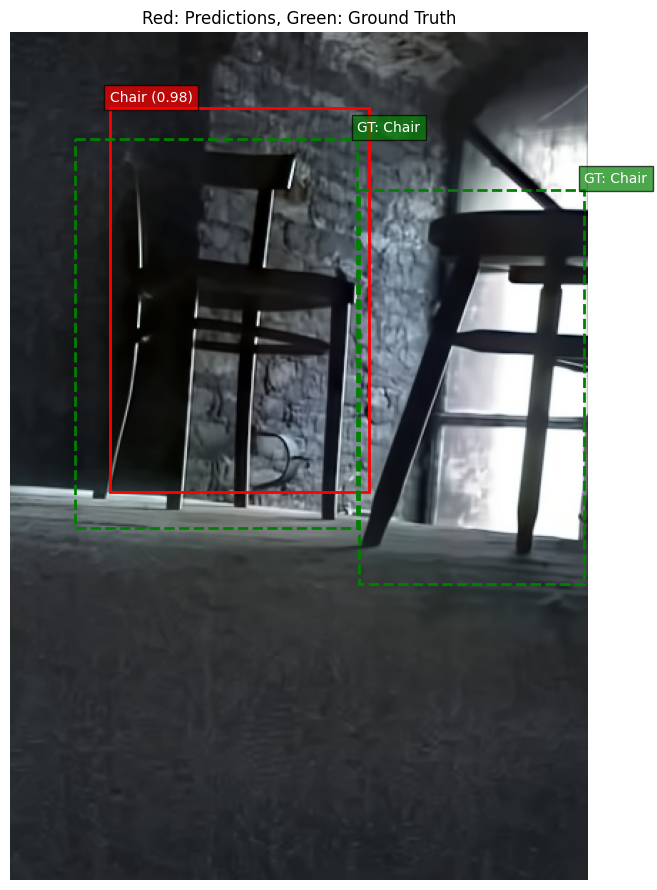

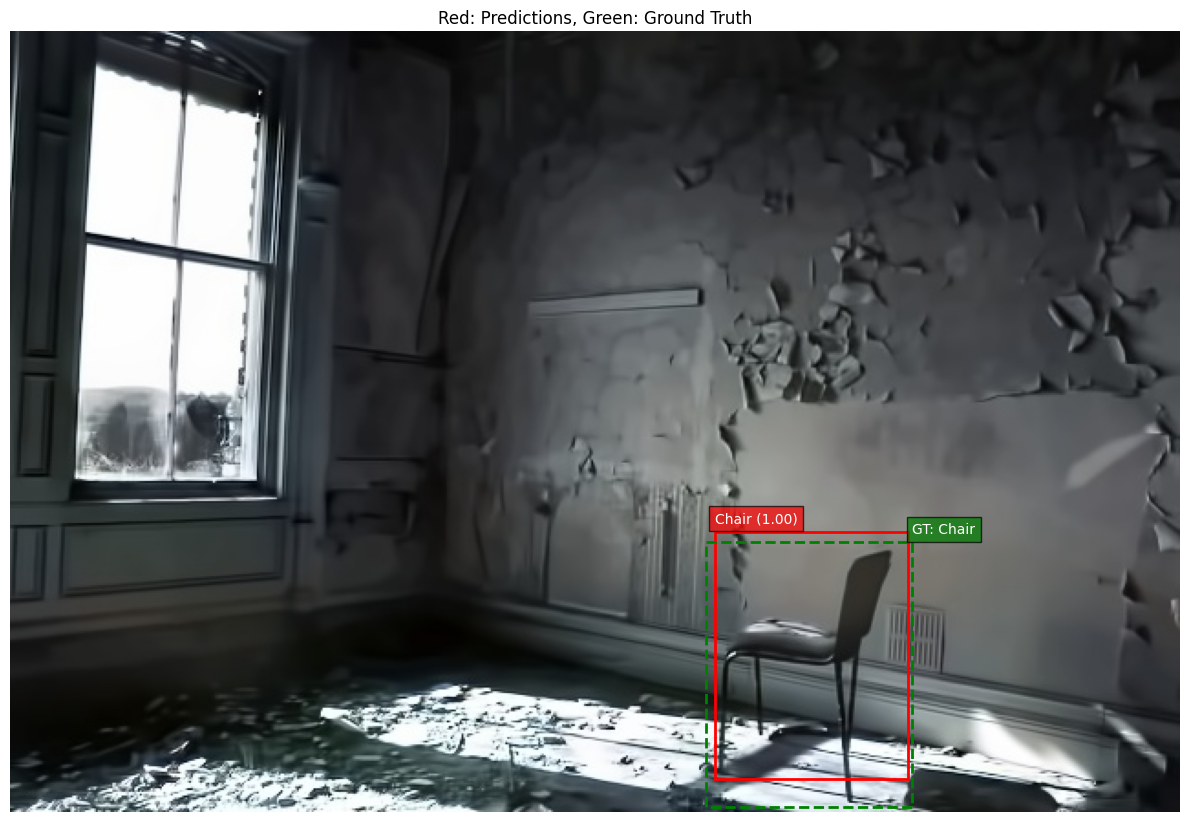

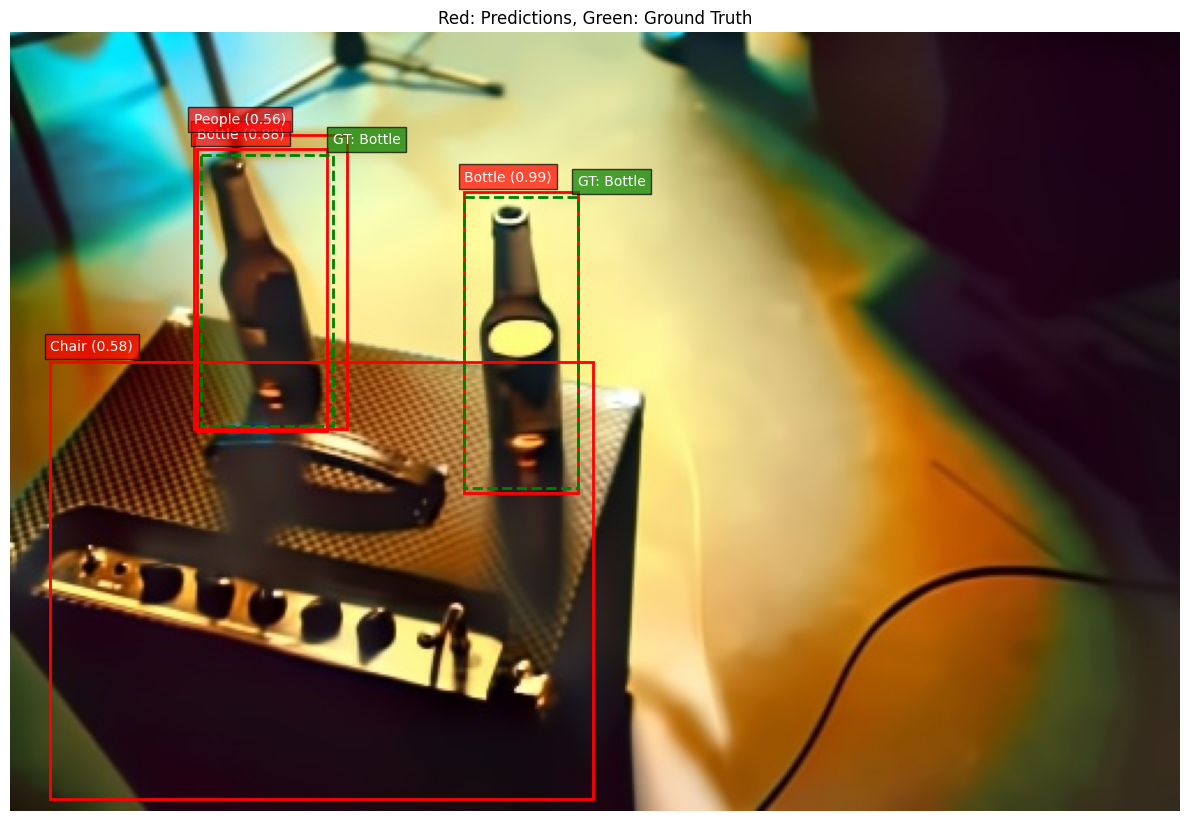

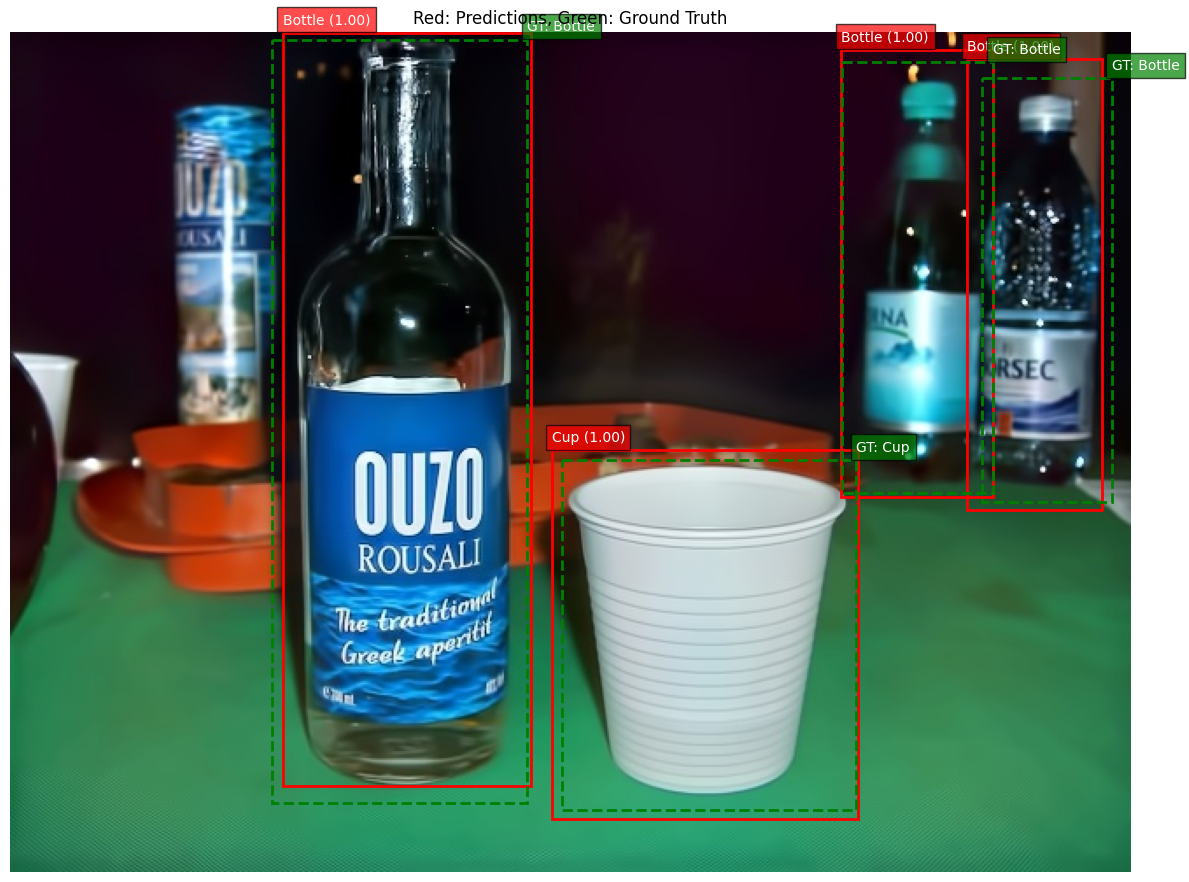

In [14]:
# Hàm hiển thị kết quả prediction
def show_prediction(model, image, target=None, idx2label=None, confidence_threshold=0.5):
    model.eval()
    with torch.no_grad():
        prediction = model([image.to(device)])[0]
        
    # Chuyển đổi bounding boxes về numpy để dễ vẽ
    boxes = prediction['boxes'].cpu().numpy()
    labels = prediction['labels'].cpu().numpy()
    scores = prediction['scores'].cpu().numpy()
    
    # Vẽ bounding boxes
    import matplotlib.pyplot as plt
    import matplotlib.patches as patches
    
    fig, ax = plt.subplots(1, figsize=(12, 9))
    
    # Chuyển đổi image tensor về format để hiển thị
    if image.shape[0] == 3:  # CHW format
        img_display = image.permute(1, 2, 0).cpu().numpy()
    else:  # HWC format
        img_display = image.cpu().numpy()
    
    # Đảm bảo pixel values trong range [0, 1]
    if img_display.max() > 1.0:
        img_display = img_display / 255.0
    
    ax.imshow(img_display)
    
    # Vẽ prediction boxes (màu đỏ)
    for box, label, score in zip(boxes, labels, scores):
        if score < confidence_threshold:  # Chỉ vẽ nếu confidence > threshold
            continue
            
        xmin, ymin, xmax, ymax = box
        width = xmax - xmin
        height = ymax - ymin
        
        rect = patches.Rectangle((xmin, ymin), width, height, linewidth=2,
                                edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        
        # Hiển thị label và score
        if idx2label and label in idx2label:
            label_name = idx2label[label]
        else:
            label_name = f"Class_{label}"
            
        ax.text(xmin, ymin-5, f"{label_name} ({score:.2f})", 
                color='white', fontsize=10,
                bbox=dict(facecolor='red', alpha=0.7))
    
    # Vẽ ground truth boxes nếu có (màu xanh lá)
    if target is not None:
        gt_boxes = target['boxes'].cpu().numpy()
        gt_labels = target['labels'].cpu().numpy()
        
        for box, label in zip(gt_boxes, gt_labels):
            xmin, ymin, xmax, ymax = box
            width = xmax - xmin
            height = ymax - ymin
            
            rect = patches.Rectangle((xmin, ymin), width, height, linewidth=2,
                                    edgecolor='g', facecolor='none', linestyle='--')
            ax.add_patch(rect)
            
            # Hiển thị ground truth label
            if idx2label and label in idx2label:
                label_name = idx2label[label]
            else:
                label_name = f"Class_{label}"
                
            ax.text(xmax, ymin-5, f"GT: {label_name}", 
                    color='white', fontsize=10,
                    bbox=dict(facecolor='green', alpha=0.7))
    
    ax.set_title("Red: Predictions, Green: Ground Truth")
    plt.axis('off')
    plt.tight_layout()
    plt.show()

# Hiển thị prediction cho một ảnh trong test set
def show_test_prediction(model, test_set, idx=0, idx2label=None):
    if idx < 0 or idx >= len(test_set):
        print(f"Index {idx} out of bounds for test set of size {len(test_set)}")
        return
    
    try:
        image, target = test_set[idx]
        show_prediction(model, image, target, idx2label)
    except Exception as e:
        print(f"Error showing prediction for index {idx}: {e}")

# Hàm tiện ích để tạo idx2label từ label2idx
def create_idx2label(label2idx):
    return {v: k for k, v in label2idx.items()}

# Sử dụng:
# Tạo mapping ngược từ index về tên class
idx2label = create_idx2label(label2idx)

# Hiển thị kết quả
show_test_prediction(model, val_set, idx=100, idx2label=idx2label)
show_test_prediction(model, test_set, idx=10, idx2label=idx2label)
show_test_prediction(model, train_set, idx=200, idx2label=idx2label)
show_test_prediction(model, test_set, idx=300, idx2label=idx2label)

In [15]:
# Vẽ sơ đồ loss và accuracy
def plot_training_history(train_losses, train_accuracies):
    epochs = range(1, len(train_losses) + 1)
    
    plt.figure(figsize=(12, 5))
    
    # Loss plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Training Loss', color='blue')
    plt.title('Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.grid()
    plt.legend()
    
    # Accuracy plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, label='Validation mAP', color='orange')
    plt.title('Validation mAP')
    plt.xlabel('Epochs')
    plt.ylabel('mAP')
    plt.grid()
    plt.legend()
    
    plt.tight_layout()
    plt.show()

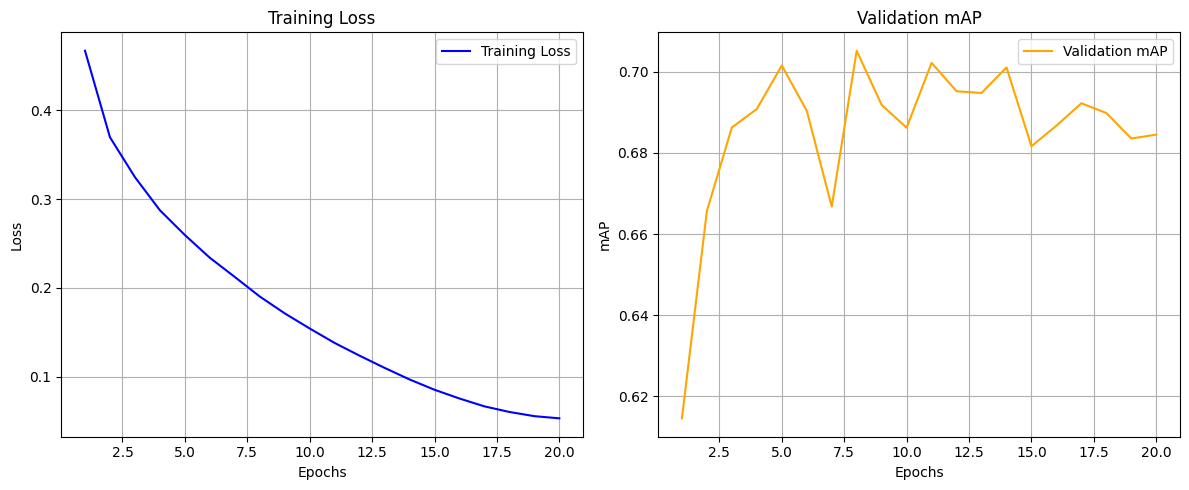

[0.4672779992384755,
 0.36978558947835466,
 0.32487071226842656,
 0.2875658568741048,
 0.25964717011065774,
 0.2340387384384084,
 0.21239990328282396,
 0.1903827366916613,
 0.17141281738761605,
 0.15435718670950171,
 0.1380732708570102,
 0.12369958070390251,
 0.11001355547359595,
 0.09694041272116281,
 0.08534197653181018,
 0.07548234470966649,
 0.06662928891044272,
 0.06032684976914724,
 0.055595077321899375,
 0.05314655042750911]

In [16]:
plot_training_history(train_losses, train_accuracies)
train_losses